# A continuation approach to the optimization of hydropower operations: Example

Authors Julia Rauw & Jorn Baayen

In [ ]:
%matplotlib inline

import casadi as ca
import numpy as np
import time

In [3]:
# Parameters
T = 2 * 24 * 3600 # 2 days
dt = 3600 # 1 hour
t = np.arange(0, T + dt, dt)
N = len(t)

# Symbols
Q_u = ca.MX.sym('Q_u', N)
Q_d = ca.MX.sym('Q_d', N)
H_u = ca.MX.sym('H_u', N)
H_d = ca.MX.sym('H_d', N)
V_u = ca.MX.sym('V_u', N)
V_d = ca.MX.sym('V_d', N)
P_u = ca.MX.sym('P_u', N)
P_d = ca.MX.sym('P_d', N)
theta = ca.MX.sym('theta')

# Upstream inflow
Q_i = np.full_like(t, 100)

# Parameters
H_b_u = 1000 # bottom level upstream
H_b_d = 900 # bottom level downstream
A_u = 50 * 2000 # surface area upstream
A_d = 50 * 2000 # surface area downstream

g = 9.81 # gravitational constant
rho = 1000.0 # density of water
eta_u = 0.85 # upstream turbine efficiency
eta_d = 0.85 # downstream turbine efficiency

Q_min_u = 0
Q_min_d = 0
Q_max_u = 100 # upstream max turbine flow
Q_max_d = 100 # downstream max turbine flow

H_max_u = H_b_u + 30
H_min_u = H_b_u
H_max_d = H_b_d + 30
H_min_d = H_b_d

P_min_u = 0
P_min_d = 0
P_max_u = 1000 # 1 GW
P_max_d = 1000 # 1 GW

V_min_u = 0.0
V_min_d = 0.0
V_max_u = np.inf 
V_max_d = np.inf 

H_t = 800 # tailwater level

# Initial values
H_u_0 = H_b_u + 5
H_d_0 = H_b_d + 25

# Head differences for linear model
dH_u_0 = H_u_0 - H_d_0
dH_d_0 = H_d_0 - H_t

# Objective funtion
f = ca.sum1(-P_u - P_d) / 1e3

# Constraints
g1 = H_u[0] - H_u_0
g2 = ( (V_u * 1e6) / A_u  + H_b_u) - H_u # Linear reservoir
g3 = H_d[0] - H_d_0
g4 = ((V_d * 1e6) / A_d  + H_b_d) - H_d # Linear reservoir
g5 = (1 - theta) * g * rho * eta_u * Q_u * dH_u_0 + \
     theta * g * rho * eta_u * Q_u * (H_u - H_d) - 1e6 * P_u    
g6 = (1 - theta) * g * rho * eta_d * Q_d * dH_d_0 + \
     theta * g * rho * eta_d * Q_d * (H_d - H_t) - 1e6 * P_d
g7 = 1e6 * (V_u[1:] - V_u[:-1]) / dt - Q_i[1:] + Q_u[1:]
g8 = 1e6 * (V_d[1:] - V_d[:-1]) / dt - Q_u[1:] + Q_d[1:] 

# Full optimization problem                                                                  
g = ca.vertcat(g1, g2, g3, g4, g5, g6, g7, g8)
lbg = np.zeros(g.size1())
ubg = np.zeros(g.size1())

X = ca.vertcat(H_u, Q_u, H_d, Q_d, P_u, P_d, V_u, V_d)
lbX = np.zeros(X.size1())
ubX = np.zeros(X.size1())

lbX[0:H_u.size1()] = H_min_u
lbX[H_u.size1():H_u.size1() + Q_u.size1()] = Q_min_u
lbX[H_u.size1() + Q_u.size1(): H_u.size1() + Q_u.size1() + \
    H_d.size1()] = H_min_d
lbX[H_u.size1() + Q_u.size1() + H_d.size1():H_u.size1() + \
    Q_u.size1() + H_d.size1() + Q_d.size1()] = Q_min_d
lbX[H_u.size1() + Q_u.size1() + H_d.size1() + \
    Q_d.size1():H_u.size1() + Q_u.size1() + H_d.size1() \
    + Q_d.size1() + P_u.size1()] = P_min_u
lbX[H_u.size1() + Q_u.size1() + H_d.size1() + \
    Q_d.size1() + P_u.size1():H_u.size1() + \
    Q_u.size1() + H_d.size1() + Q_d.size1() + \
    P_u.size1() + P_d.size1()] = P_min_d
lbX[H_u.size1() + Q_u.size1() + H_d.size1() + \
    Q_d.size1() + P_u.size1() + P_d.size1():H_u.size1() + \
    Q_u.size1() + H_d.size1() + Q_d.size1() + \
    P_u.size1() + P_d.size1() + V_u.size1()] = V_min_u
lbX[H_u.size1() + Q_u.size1() + H_d.size1() + \
    Q_d.size1() + P_u.size1() + P_d.size1() + \
    V_u.size1():H_u.size1() + Q_u.size1() + \
    H_d.size1() + Q_d.size1() + P_u.size1() + \
    P_d.size1() + V_u.size1()+ V_d.size1()] = V_min_d

ubX[0:H_u.size1()] = H_max_u
ubX[H_u.size1():H_u.size1() + Q_u.size1()] = Q_max_u
ubX[H_u.size1() + Q_u.size1(): H_u.size1() + Q_u.size1() + \
    H_d.size1()] = H_max_d
ubX[H_u.size1() + Q_u.size1() + H_d.size1():H_u.size1() + \
    Q_u.size1() + H_d.size1() + Q_d.size1()] = Q_max_d
ubX[H_u.size1() + Q_u.size1() + H_d.size1() + \
    Q_d.size1():H_u.size1() + Q_u.size1() + \
    H_d.size1() + Q_d.size1() + P_u.size1()] = P_max_u
ubX[H_u.size1() + Q_u.size1() + H_d.size1() + \
    Q_d.size1() + P_u.size1():H_u.size1() + \
    Q_u.size1() + H_d.size1() + Q_d.size1() + \
    P_u.size1() + P_d.size1()] = P_max_d
ubX[H_u.size1() + Q_u.size1() + H_d.size1() + \
    Q_d.size1() + P_u.size1() + P_d.size1():H_u.size1() + \
    Q_u.size1() + H_d.size1() + Q_d.size1() + \
    P_u.size1() + P_d.size1() + V_u.size1()] = V_max_u
ubX[H_u.size1() + Q_u.size1() + H_d.size1() + \
    Q_d.size1() + P_u.size1() + P_d.size1() + \
    V_u.size1():H_u.size1() + Q_u.size1() + \
    H_d.size1() + Q_d.size1() + P_u.size1() + \
    P_d.size1() + V_u.size1()+ V_d.size1()] = V_max_d

# Initial guess
X0 = 0

# Solve
t1 = time.time()

solver = ca.nlpsol('solver', 'ipopt', {'x': X, 'f': f, 'g': g, 'p': theta}, {'ipopt': {}})
theta_values = np.linspace(0.0, 1.0, 11)
results = []
for theta_value in theta_values:
    sol = solver(lbg = lbg, ubg = ubg, lbx = lbX, ubx = ubX, p = theta_value, x0 = X0)
    X0 = sol['x']
    d = {}
    d['H_u'] = X0[0:H_u.size1()]
    d['Q_u'] = X0[H_u.size1():H_u.size1() + Q_u.size1()]
    d['H_d'] = X0[H_u.size1() + Q_u.size1():H_u.size1() + \
                  Q_u.size1() + H_d.size1()]
    d['Q_i'] = Q_i
    d['Q_d'] = X0[H_u.size1() + Q_u.size1() + \
                  H_d.size1():H_u.size1() + Q_u.size1() + \
                  H_d.size1() + Q_d.size1()]
    d['P_u'] = X0[H_u.size1() + Q_u.size1() + H_d.size1() + \
                  Q_d.size1():H_u.size1() + Q_u.size1() + \
                  H_d.size1() + Q_d.size1() + P_u.size1()]
    d['P_d'] = X0[H_u.size1() + Q_u.size1() + H_d.size1() + \
                  Q_d.size1() + P_u.size1():H_u.size1() + \
                  Q_u.size1() + H_d.size1() + Q_d.size1() + \
                  P_u.size1() + P_d.size1()]
    d['P'] = d['P_u'] + d['P_d']
    d['V_u'] = X0[H_u.size1() + Q_u.size1() + H_d.size1() + \
                  Q_d.size1() + P_u.size1() + P_d.size1():H_u.size1() + \
                  Q_u.size1() + H_d.size1() + Q_d.size1() + \
                  P_u.size1() + P_d.size1() + V_u.size1()]
    d['V_d'] = X0[H_u.size1() + Q_u.size1() + H_d.size1() + \
                  Q_d.size1() + P_u.size1() + P_d.size1() + V_u.size1():H_u.size1() + \
                  Q_u.size1() + H_d.size1() + Q_d.size1() + \
                  P_u.size1() + P_d.size1() + V_u.size1() + V_d.size1()]  
    results.append(d)

t2 = time.time()

print('Time elapsed in solver: {}s'.format(t2 - t1))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      877
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      147

Total number of variables............................:      392
                     variables with only lower bounds:       98
                variables with lower and upper bounds:      294
                     variables with only upper bounds:        0
Total number of equality constraints.................:      294
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

  20 -8.3583259e+00 3.52e+02 1.50e-09  -3.8 1.21e+00    -  1.00e+00 1.00e+00h  1
  21 -8.3583280e+00 6.79e-01 1.50e-09  -3.8 5.32e-02    -  1.00e+00 1.00e+00h  1
  22 -8.3669251e+00 2.53e+04 1.11e-04  -5.7 2.45e+01    -  7.93e-01 4.19e-01f  1
  23 -8.3718201e+00 1.27e+04 9.00e-05  -5.7 2.61e+00    -  1.00e+00 4.99e-01h  1
  24 -8.3758649e+00 1.09e+02 2.79e-07  -5.7 2.60e-01    -  1.00e+00 9.97e-01h  1
  25 -8.3758422e+00 1.61e-01 1.84e-11  -5.7 1.36e-02    -  1.00e+00 1.00e+00h  1
  26 -8.3760207e+00 2.86e-01 5.35e-08  -8.6 2.10e-02    -  1.00e+00 9.85e-01h  1
  27 -8.3760231e+00 2.15e-05 2.51e-14  -8.6 1.00e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 27

                                   (scaled)                 (unscaled)
Objective...............:  -8.3760230740665271e+00   -8.3760230740665271e+00
Dual infeasibility......:   2.5100765651339222e-14    2.5100765651339222e-14
Constraint violation....:   2.1532177925109862e-09    2.1532177925109863e-05
Complementarity....

  20 -8.5111416e+00 8.87e+04 2.35e-08  -3.8 1.20e+01    -  1.00e+00 1.00e+00h  1
  21 -8.5110879e+00 1.02e+02 1.50e-09  -3.8 6.56e-01    -  1.00e+00 1.00e+00h  1
  22 -8.5110874e+00 3.28e-02 1.50e-09  -3.8 8.53e-03    -  1.00e+00 1.00e+00h  1
  23 -8.5285182e+00 5.32e+05 5.30e-05  -5.7 2.25e+01    -  6.84e-01 8.62e-01f  1
  24 -8.5309592e+00 2.90e+05 2.94e-05  -5.7 2.02e+01    -  5.66e-01 7.22e-01h  1
  25 -8.5318690e+00 1.76e+05 2.05e-08  -5.7 1.37e+01    -  1.00e+00 1.00e+00h  1
  26 -8.5318359e+00 3.46e+04 3.82e-09  -5.7 6.24e+00    -  1.00e+00 1.00e+00h  1
  27 -8.5318018e+00 1.20e+03 2.66e-10  -5.7 1.17e+00    -  1.00e+00 1.00e+00h  1
  28 -8.5318003e+00 6.14e+00 1.84e-11  -5.7 9.50e-02    -  1.00e+00 1.00e+00h  1
  29 -8.5318003e+00 2.40e-04 1.84e-11  -5.7 9.12e-04    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -8.5320080e+00 6.95e+03 1.43e-06  -8.6 2.77e+00    -  8.08e-01 9.52e-01h  1
  31 -8.5320068e+00 5.08e+02

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


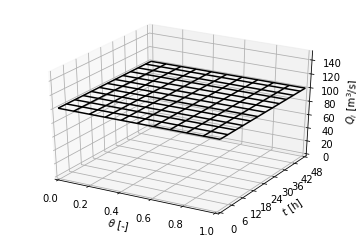

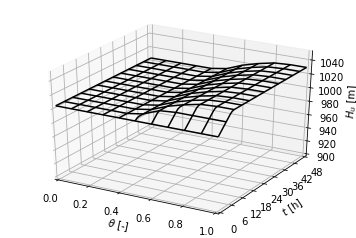

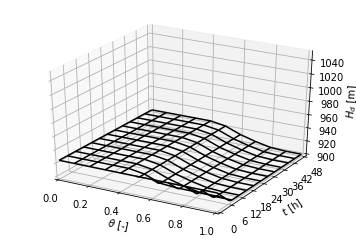

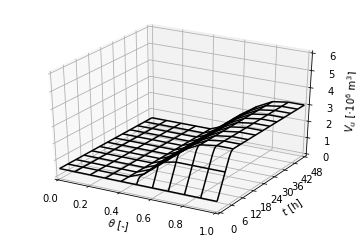

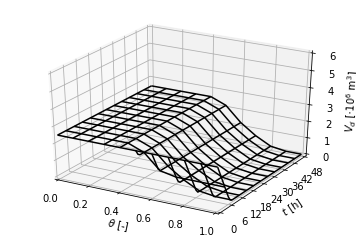

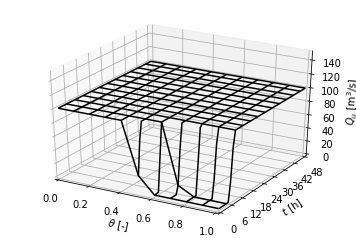

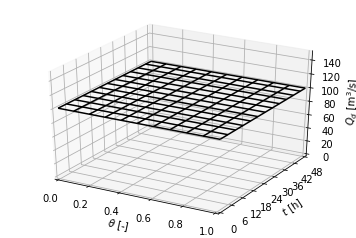

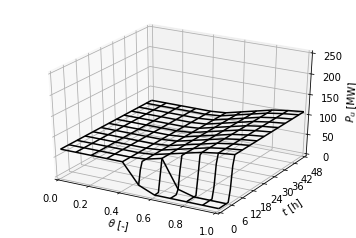

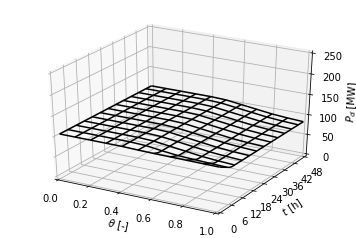

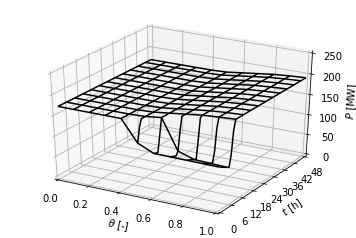

In [7]:
# Generate plots using matplotlib
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

for key in ['Q_i', 'H_u', 'H_d', 'V_u', 'V_d', 'Q_u', 'Q_d', 'P_u', 'P_d', 'P']:
    if key.startswith('Q'):
        unit = 'm$^3$/s'
        skip_t0 = True
    elif key.startswith('P'):
        unit = 'MW'
        skip_t0 = True
    elif key.startswith('V'):
        unit = '$\cdot 10^6$ m$^3$'
        skip_t0 = False
    elif key.startswith('H'):
        unit = 'm'
        skip_t0 = False
    else:
        raise KeyError

    if skip_t0:
        t_ = t[1:]
    else:
        t_ = t

    X, Y = np.meshgrid(theta_values, t_)
    Z = np.zeros(X.shape)

    for i in range(len(theta_values)):
        if skip_t0:
            Z[:, i] = np.transpose(results[i][key][1:])
        else:
            Z[:, i] = np.transpose(results[i][key])

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel(r'$\theta$ [-]')
    ax.set_ylabel(r'$t$ [h]')
    ax.set_zlabel('${}$ [{}]'.format(key, unit))
    ax.set_xlim(0, 1)
    ax.set_ylim(t[0], t[-1])

    if key.startswith('H'):
        ax.set_zlim(900, 1050)
    elif key.startswith('V'):
        ax.set_zlim(0, 6)
    elif key.startswith('Q'):
        ax.set_zlim(0, 150)
    else:
        ax.set_zlim(0, 250)

    ax.plot_wireframe(X, Y, Z, rstride=4, cstride=1, color='black')

    ax.set_yticks(np.arange(0, T + dt, 6 * dt))
    ax.set_yticklabels(('{}'.format(int(ytick / 3600.)) for ytick in ax.get_yticks()))

    fig.show()
    plt.savefig('{}.pdf'.format(key))

In [26]:
dP = np.array(results[-1]['P'][1:] - results[0]['P'][1:]).flatten()
dE = sum(dP) * dt / 3600.0 # MWh
print('Nonlinear solution produces {:.2f} MWh more energy than linear solution'.format(dE))

percentage_points = 100.0 * (sum(np.array(results[-1]['P'][1:]).flatten()) / sum(np.array(results[0]['P'][1:]).flatten()) - 1.0)
print('Nonlinear solution produces {:.2f}% more energy than linear solution'.format(percentage_points))

Nonlinear solution produces 310.17 MWh more energy than linear solution
Nonlinear solution produces 3.78% more energy than linear solution
